In [1]:
# Activate packages
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from tqdm import tqdm  # Add this import

c:\Users\au702451\OneDrive - Aarhus universitet\Dokumenter\GitHub\DatSci25\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
# Load the CSV file
df = pd.read_csv('../data/PBramsCleaned/clean_parlamint3.csv')

# Filter rows containing the word "klima" in the 'text' column
filtered_df = df[df['text'].str.contains('klima', case=False, na=False)]

# Display the filtered rows
filtered_df.head()

,Unnamed: 0,ID,Title_of_proceeding,Date,Body,Term,Session,Meeting,Sitting,Agenda,...,Speaker_party,Speaker_party_name,Party_status,Speaker_name,Speaker_gender,Speaker_birth,text,Source_data,Year,YearMonth
11,11,ParlaMint-DK_20141008130437,Hansard of the session of the Danish Parliamen...,2014-10-08,Unicameralism,NaN,20141.0,2.0,NaN,NaN,...,S,Socialdemokratiet,Coalition,"Lykketoft, Mogens",M,1946,Til disse valg er anmeldt følgende valggrupper...,ParlaMint3,2014,2014-10
310,310,ParlaMint-DK_20141009135804,Hansard of the session of the Danish Parliamen...,2014-10-09,Unicameralism,NaN,20141.0,3.0,NaN,NaN,...,RV,Radikale Venstre,Coalition,"Hersom, Camilla",F,1971,"Den dag, vi holder Folketingets åbningsdebat, ...",ParlaMint3,2014,2014-10
400,400,ParlaMint-DK_20141009145943,Hansard of the session of the Danish Parliamen...,2014-10-09,Unicameralism,NaN,20141.0,3.0,NaN,NaN,...,SF,Socialistisk Folkeparti,NaN,"Dyhr, Pia Olsen",F,1971,"Danmark er et af verdens rigeste, tryggeste og...",ParlaMint3,2014,2014-10
410,410,ParlaMint-DK_20141009151429,Hansard of the session of the Danish Parliamen...,2014-10-09,Unicameralism,NaN,20141.0,3.0,NaN,NaN,...,KF,Det Konservative Folkeparti,Opposition,"Barfoed, Lars",M,1957,På trods af en lidt svigtende stemme lykkedes ...,ParlaMint3,2014,2014-10
412,412,ParlaMint-DK_20141009151530,Hansard of the session of the Danish Parliamen...,2014-10-09,Unicameralism,NaN,20141.0,3.0,NaN,NaN,...,SF,Socialistisk Folkeparti,NaN,"Dyhr, Pia Olsen",F,1971,"Jeg synes, det er meget tankevækkende, at De K...",ParlaMint3,2014,2014-10


In [3]:
# Display the filtered rows - first element in text column
filtered_df.iloc[0]

Unnamed: 0                                                            11
ID                                           ParlaMint-DK_20141008130437
Title_of_proceeding    Hansard of the session of the Danish Parliamen...
Date                                                          2014-10-08
Body                                                       Unicameralism
Term                                                                 NaN
Session                                                          20141.0
Meeting                                                              2.0
Sitting                                                              NaN
Agenda                                                               NaN
Subcorpus                                                      Reference
Speaker_role                                                 Chairperson
Speaker_MP                                                            MP
Speaker_Minister                                   

In [8]:

from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("Maltehb/danish-bert-botxo")
model = AutoModel.from_pretrained("Maltehb/danish-bert-botxo")

# Sample 200 rows and reset index
sampled_df = filtered_df.sample(n=2000, random_state=42).reset_index(drop=True)

# Define target tokens
target_tokens = ["klima", "klimaet"]
target_ids = tokenizer.convert_tokens_to_ids(target_tokens)

# Store embeddings
rows = []

# Add progress bar
for index, row in tqdm(sampled_df.iterrows(), total=len(sampled_df), desc="Embedding rows"):
    sentence = row['text']
    speaker_name = row['Speaker_name']
    year_month = row['YearMonth']
    
    # Tokenize with truncation
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=512)
    input_ids = inputs["input_ids"][0]
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden_state = outputs.last_hidden_state[0]

    # Save embeddings for relevant tokens
    for idx, token_id in enumerate(input_ids):
        if token_id.item() in target_ids:
            embedding = last_hidden_state[idx].numpy()
            token_str = tokens[idx]
            rows.append({
                "Speaker_name": speaker_name,
                "text": sentence,
                "YearMonth": year_month,
                "token": token_str,
                **{f"dim_{i}": val for i, val in enumerate(embedding)}
            })

# Build final DataFrame
df = pd.DataFrame(rows)
# Get the index of 'YearMonth' column
ym_index = df.columns.get_loc('YearMonth')
# Split 'YearMonth' into 'Year' and 'Month'
year_month_split = df['YearMonth'].str.split('-', expand=True)
df.insert(ym_index + 1, 'Year', year_month_split[0].astype(int))
df.insert(ym_index + 2, 'Month', year_month_split[1].astype(int))


df.head()

Embedding rows: 100%|██████████| 2000/2000 [14:02<00:00,  2.37it/s]


,Speaker_name,text,YearMonth,Year,Month,token,dim_0,dim_1,dim_2,dim_3,...,dim_758,dim_759,dim_760,dim_761,dim_762,dim_763,dim_764,dim_765,dim_766,dim_767
0,"Christensen, Peter Seier",Tak for det. Lovforslaget omhandler ændring af...,2021-02,2021,2,klima,-0.216606,-0.300648,0.500006,2.254119,...,0.587648,-1.305903,-0.099506,-0.963381,-0.630188,-0.122345,-0.303434,0.085840,1.950415,0.506151
1,"Juul, Mona",Tak for ordet. Jeg speeder bare lidt op. Jeg v...,2021-03,2021,3,klima,-0.074149,-0.300526,1.183441,0.637031,...,-0.100696,-0.943231,0.824995,0.026593,-1.305756,-1.275800,-1.272572,-0.618197,0.816465,1.081226
2,"Juul, Mona",Tak for ordet. Jeg speeder bare lidt op. Jeg v...,2021-03,2021,3,klima,0.752920,-0.155747,0.641007,0.174230,...,-0.292826,-1.075073,0.335597,0.965078,-0.108892,-1.088379,-1.026628,0.091898,1.453910,0.962388
3,"Juul, Mona",Tak for ordet. Jeg speeder bare lidt op. Jeg v...,2021-03,2021,3,klima,0.076567,-0.259161,1.744688,0.790372,...,0.393222,-1.130031,0.798620,0.065804,-0.794831,-1.069574,-0.757666,0.121613,1.212852,1.108533
4,"Juul, Mona",Tak for ordet. Jeg speeder bare lidt op. Jeg v...,2021-03,2021,3,klima,0.086335,-0.281012,1.721929,0.753223,...,0.403996,-1.132138,0.825979,0.090052,-0.776828,-1.051439,-0.734574,0.123320,1.242143,1.129405


In [9]:
from sklearn.decomposition import PCA
import pandas as pd

# Select embeddings
embeddings = df.iloc[:, 6:]

# Perform PCA with 2 components
pca = PCA(n_components=10)
pca_result = pca.fit_transform(embeddings)

# Get variance explained
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PC1 and PC2: {explained_variance[0]:.2%}, {explained_variance[1]:.2%}")

# Create new DataFrame with original first 4 columns and PCA results
pca_df = df.iloc[:, :6].copy()
pca_df['PC1'] = pca_result[:, 0]
pca_df['PC2'] = pca_result[:, 1]

# Show the result
pca_df

# Sort by Month, then Year
pca_df_sorted = pca_df.sort_values(by=['Year', 'Month']).reset_index(drop=True)

# Show the result
pca_df_sorted


Explained variance by PC1 and PC2: 14.10%, 10.68%


,Speaker_name,text,YearMonth,Year,Month,token,PC1,PC2
0,"Olsen, Johan Lund","Tak, vil jeg sige til fru Zenia Stampe. Jeg la...",2014-10,2014,10,klima,5.080647,0.906142
1,"Bergmann, Mie",Som de andre ordførere har været inde på med h...,2014-10,2014,10,klima,-6.771621,-4.056947
2,"Lind, Annette",Jeg vil gerne på Socialdemokraternes vegne sta...,2014-10,2014,10,klima,-4.051260,2.547966
3,"Hav, Orla",Tak for det. For Socialdemokraterne er det vig...,2014-10,2014,10,klima,-12.872480,-2.405231
4,"Hav, Orla",Tak for det. For Socialdemokraterne er det vig...,2014-10,2014,10,klimaet,-16.324041,-4.261337
...,...,...,...,...,...,...,...,...
2559,"Jørgensen, Dan","Ja, men Klimarådet har selv taget markant afst...",2022-06,2022,6,klima,1.831307,1.494276
2560,"Jørgensen, Dan","Der bliver sagt, at man har forståelse for, hv...",2022-06,2022,6,klima,-11.877169,-3.232626
2561,"Rasmussen, Søren Egge","Jamen altså, det er jo rigtigt, at Klimarådet ...",2022-06,2022,6,klima,-0.203365,-5.820075
2562,"Gejl, Torsten","Tak, og tak for redegørelsen. Jeg vil lige for...",2022-06,2022,6,klima,3.470329,-6.240651


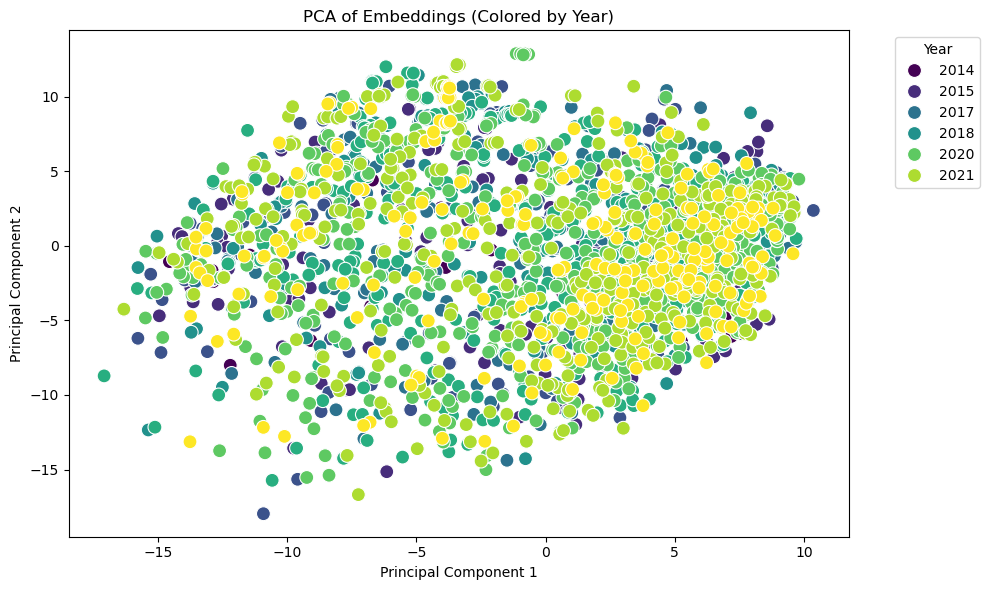

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Create the plot
plt.figure(figsize=(10, 6))

# Plot the first two PCA dimensions (PC1 vs PC2), coloring by 'Year'
sns.scatterplot(x=pca_df_sorted['PC1'], y=pca_df_sorted['PC2'], hue=pca_df_sorted['Year'], palette='viridis', s=100)

# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Embeddings (Colored by Year)')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.savefig('pca_plot.png', bbox_inches='tight')
plt.show()


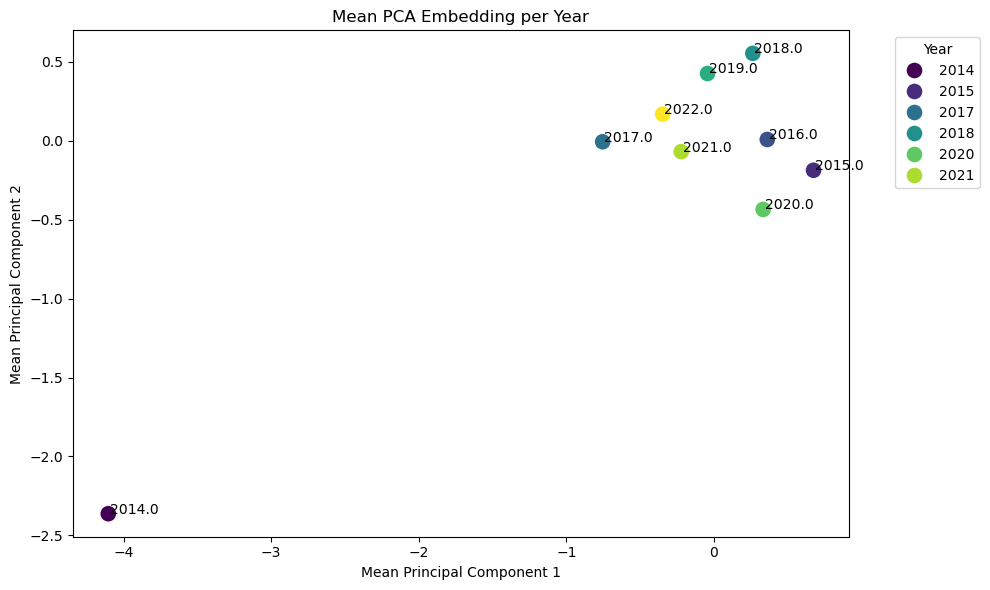

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by Year and compute mean PC1 and PC2
mean_pca_by_year = pca_df_sorted.groupby('Year')[['PC1', 'PC2']].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=mean_pca_by_year, x='PC1', y='PC2', hue='Year', palette='viridis', s=150)

# Annotate with year labels
for _, row in mean_pca_by_year.iterrows():
    plt.text(row['PC1'] + 0.01, row['PC2'], str(row['Year']), fontsize=10)

# Labels and title
plt.xlabel('Mean Principal Component 1')
plt.ylabel('Mean Principal Component 2')
plt.title('Mean PCA Embedding per Year')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
